In [21]:
from sklearn.linear_model import LinearRegression

In [1]:
import torchaudio
waveform,sample_rate = torchaudio.load("/kaggle/input/audio-file/Taqdeer.mp3")
# Loading the audio
waveform = waveform.mean(0)
# Converting stereo(2 channels) to mono(1 channel) by taking mean of 2 channels
original_audio = waveform[:5*sample_rate]
# Trimming to first 5 seconds

In [2]:
from IPython.display import Audio
Audio(original_audio,rate=sample_rate) # Displaying the original audio

In [3]:
import matplotlib.pyplot as plt
import numpy as np
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

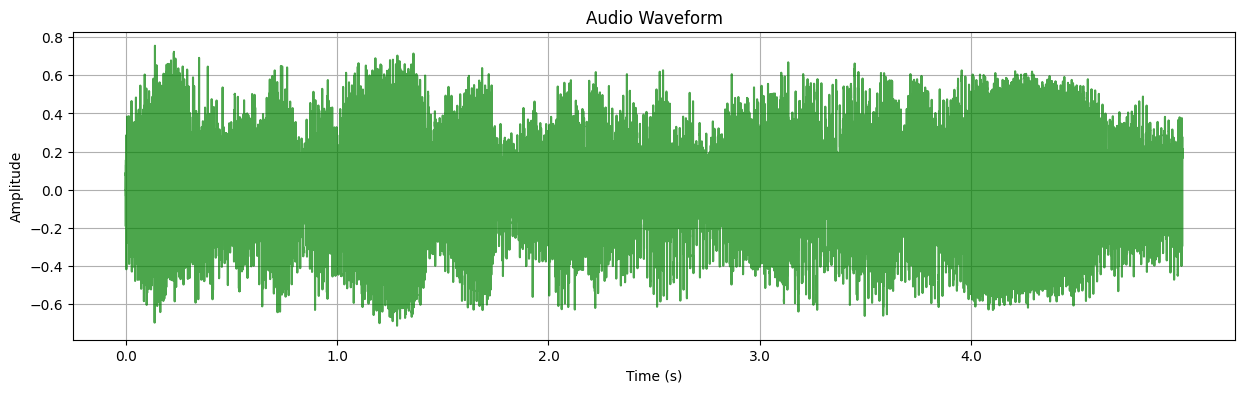

In [4]:
audio_plot(original_audio,sample_rate,"green","Audio Waveform")

In [5]:
import torch
X = torch.arange(0, len(original_audio)).unsqueeze(1).float()
X = X / X.max() * 300 - 150 # Converting 0 to 220500 points into [-150,150]
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-150.0000],
        [-149.9986],
        [-149.9973],
        ...,
        [ 149.9973],
        [ 149.9986],
        [ 150.0000]])


In [6]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Setting a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [7]:
from sklearn.metrics import mean_squared_error
def calculate_metrics(original_signal, reconstructed_signal):
    rmse = np.sqrt(mean_squared_error(original_signal, reconstructed_signal))
    snr = 10 * np.log10(np.sum(original_signal ** 2) / np.sum((original_signal - reconstructed_signal) ** 2))
    return rmse, snr

In [12]:
num_features = 5000
sigmas = [0.005,0.008,0.01,0.02,0.025,0.03,0.05]
rmse_values = []
snr_values = []
for sigma in sigmas:
    X_rff = create_rff_features(X, num_features, sigma)
    model = LinearRegression()
    model.fit(X_rff.numpy(), original_audio)
    pred_audio = model.predict(X_rff.numpy())
    RMSE,SNR = calculate_metrics(original_audio.numpy(),pred_audio)
    rmse_values.append(RMSE)
    snr_values.append(SNR)
    print(f"RMSE for sigma val={sigma}: {RMSE:.4f}")
    print(f"SNR for sigma val={sigma}: {SNR:.4f} dB")

RMSE for sigma val=0.005: 0.2145
SNR for sigma val=0.005: 1.2517 dB
RMSE for sigma val=0.008: 0.2034
SNR for sigma val=0.008: 1.7173 dB
RMSE for sigma val=0.01: 0.1997
SNR for sigma val=0.01: 1.8725 dB
RMSE for sigma val=0.02: 0.1344
SNR for sigma val=0.02: 5.3151 dB
RMSE for sigma val=0.025: 0.1119
SNR for sigma val=0.025: 6.9035 dB
RMSE for sigma val=0.03: 0.1588
SNR for sigma val=0.03: 3.8668 dB
RMSE for sigma val=0.05: 0.1741
SNR for sigma val=0.05: 3.0641 dB


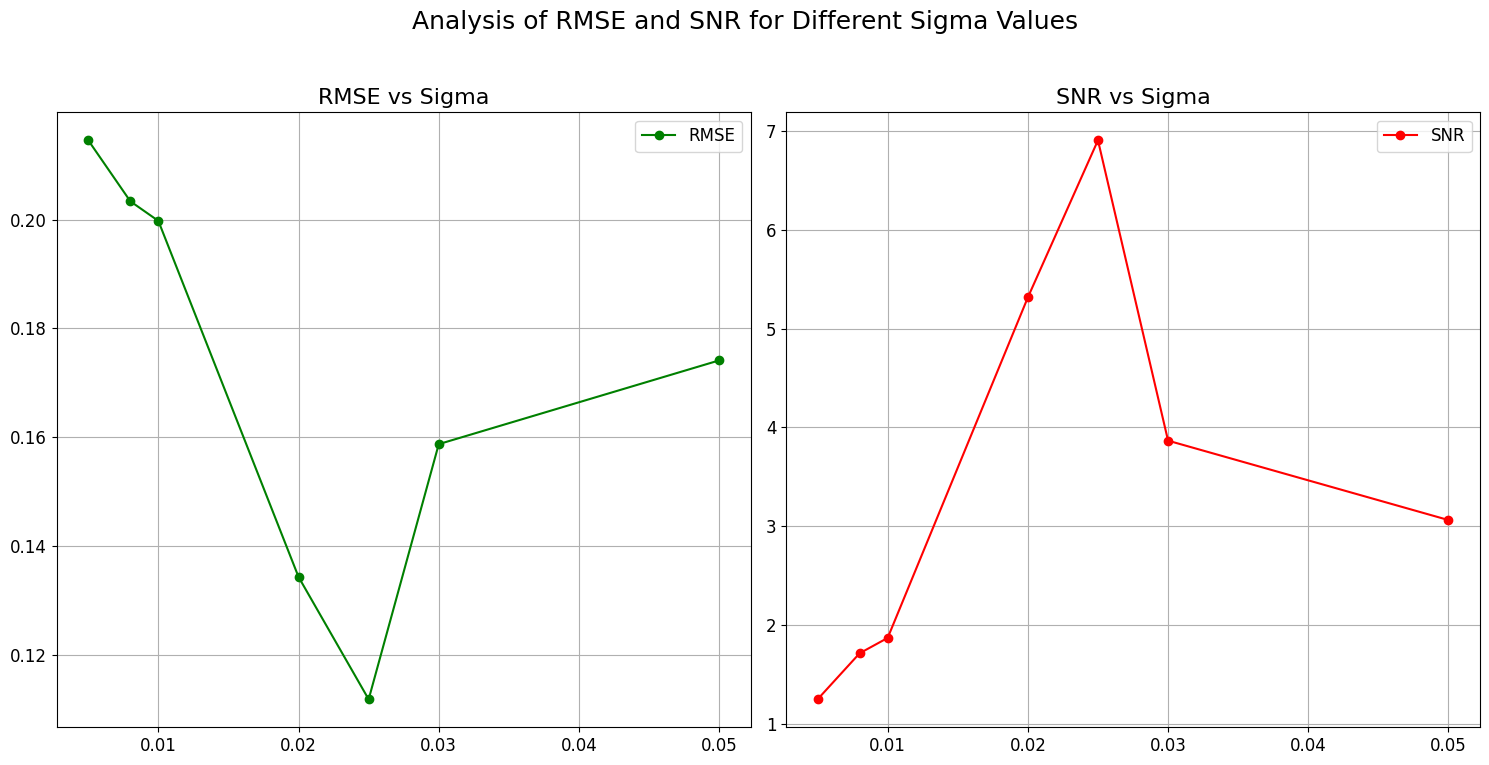

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# First subplot: RMSE vs Sigma
plt.subplot(1, 2, 1)
plt.plot(sigmas, rmse_values, marker='o', color='g', label='RMSE')
plt.title('RMSE vs Sigma', fontsize=16)
plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Second subplot: SNR vs Sigma
plt.subplot(1, 2, 2)
plt.plot(sigmas, snr_values, marker='o', color='r', label='SNR')
plt.title('SNR vs Sigma', fontsize=16)
plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a main title for both subplots
plt.suptitle('Analysis of RMSE and SNR for Different Sigma Values', fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the main title
plt.show()

* Based on the graph, the RMSE reaches its minimum at a sigma value of 0.025, and the SNR is maximized at this point as well. Before this value, from 0.005 to 0.02, the RMSE decreases steadily, but after 0.025, it begins to rise again. The SNR follows an opposite trend, decreasing after reaching its peak at 0.025. Therefore, the optimal sigma value is 0.025, where both RMSE is minimized and SNR is maximized.

In [14]:
num_features = 5000
sigma = 0.025

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 5000])
tensor([[ 0.0108,  0.0034,  0.0195,  ...,  0.0146, -0.0191, -0.0168],
        [ 0.0113,  0.0036,  0.0196,  ...,  0.0121, -0.0189, -0.0163],
        [ 0.0117,  0.0037,  0.0198,  ...,  0.0093, -0.0186, -0.0157],
        ...,
        [-0.0199,  0.0108,  0.0189,  ..., -0.0045,  0.0023, -0.0016],
        [-0.0200,  0.0109,  0.0191,  ..., -0.0077,  0.0032, -0.0025],
        [-0.0200,  0.0110,  0.0193,  ..., -0.0107,  0.0040, -0.0034]])


In [15]:
model = LinearRegression()
model.fit(X_rff.numpy(), original_audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)


In [16]:
RMSE,SNR = calculate_metrics(original_audio.numpy(),pred_audio)
print(f"RMSE: {RMSE:.4f}")
print(f"SNR: {SNR:.4f} dB")

RMSE: 0.1119
SNR: 6.9035 dB


In [20]:
L2_norm=np.linalg.norm(pred_audio - original_audio.numpy())
L1_norm=np.linalg.norm((pred_audio - original_audio.numpy()), ord = 1)
print(f"L1 Norm: {L1_norm}")
print(f"L2 Norm: {L2_norm}")

L1 Norm: 19501.431640625
L2 Norm: 52.55756759643555


In [32]:
from IPython.display import Audio, display

print("Original Audio:")
display(Audio(original_audio, rate=sample_rate))  

print("Predicted Audio:")
display(Audio(pred_audio, rate=sample_rate))

Original Audio:


Predicted Audio:


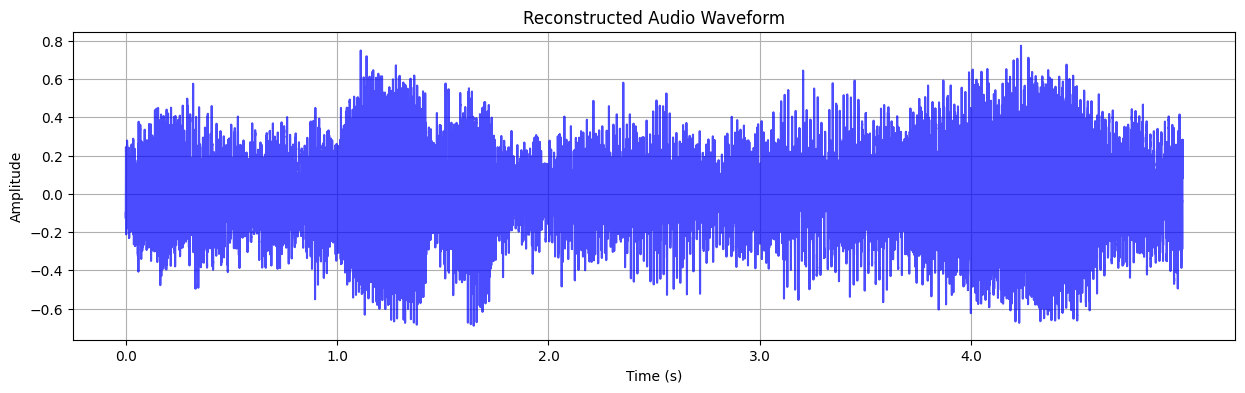

In [18]:
audio_plot(pred_audio, sample_rate, 'blue', 'Reconstructed Audio Waveform')

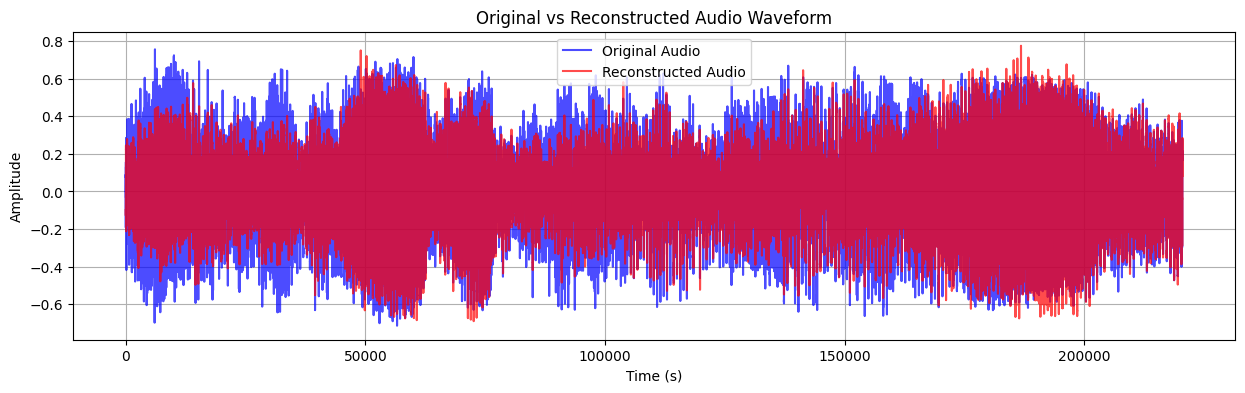

In [19]:
plt.figure(figsize=(15, 4))
plt.plot(original_audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()